# Простой POS-tagger на основне условных случайных полей (CRF)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
from itertools import chain

import nltk
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import RandomizedSearchCV

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Будем использовать данные из MorphoRuEval: возьмем размеченные предложения из Открытого корпуса, разделим их на две части, обучающую (30000 предложений) и тестовую (все остальное). 

Ссылка на файл с данными: http://localhost:8888/notebooks/RU_MorphoRuEval_CRF.ipynb

In [3]:
train_file = '/NLP/data/morphoRuEval/unamb_sent_14_6.conllu'

In [4]:
%%time
from nltk.corpus.reader.conll import *
train_reader = ConllCorpusReader(root = '', fileids = [train_file], columntypes = ['ignore', 'words', 'ignore', 'pos', 'chunk'])


sents = list(train_reader.iob_sents())
train_sents = sents[:30000]
test_sents = sents[30000:]

print(len(train_sents))
print(len(test_sents))

30000
8508
CPU times: user 12.7 s, sys: 767 ms, total: 13.5 s
Wall time: 14.2 s


In [5]:
train_sents[0]

[('«', 'PUNCT', '_'),
 ('Школа', 'NOUN', '_'),
 ('злословия', 'NOUN', '_'),
 ('»', 'PUNCT', '_'),
 ('учит', 'VERB', '_'),
 ('прикусить', 'VERB', '_'),
 ('язык', 'NOUN', '_')]

## Признаковое пространство 

In [6]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]
    
    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'word[-2:]': word[-2:],
        'word[:2]': word[:2].lower(),
    }
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:word[-2:]': word1[-2:],
            '-1:word[:2]': word1[:2].lower(),
        })
    else:
        features['BOS'] = True
        
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:word[-2:]': word1[-2:],
            '+1:word[:2]': word1[:2].lower(),
        })
    else:
        features['EOS'] = True
                
    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [postag for token, postag, label in sent]

def sent2tokens(sent):
    return [postag for token, postag, label in sent]

И вот что получится

In [7]:
sent2features(train_sents[0])[1]

{'+1:word.istitle()': False,
 '+1:word.isupper()': False,
 '+1:word.lower()': 'злословия',
 '+1:word[-2:]': 'ия',
 '+1:word[:2]': 'зл',
 '-1:word.istitle()': False,
 '-1:word.isupper()': False,
 '-1:word.lower()': '«',
 '-1:word[-2:]': '«',
 '-1:word[:2]': '«',
 'bias': 1.0,
 'word.isdigit()': False,
 'word.istitle()': True,
 'word.isupper()': False,
 'word.lower()': 'школа',
 'word[-2:]': 'ла',
 'word[:2]': 'шк'}

Извлекаем признаки из данных

In [8]:
sent2labels(train_sents[0])[1]

'NOUN'

In [9]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_test = [sent2features(s) for s in test_sents]
y_test = [sent2labels(s) for s in test_sents]

CPU times: user 3.2 s, sys: 328 ms, total: 3.53 s
Wall time: 3.72 s


## Обучение


In [10]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 1min 41s, sys: 1.6 s, total: 1min 43s
Wall time: 1min 47s


## Оценка качества


In [11]:
labels = list(crf.classes_)
labels

['PUNCT',
 'NOUN',
 'VERB',
 'PART',
 'ADP',
 'ADJ',
 'PRON',
 'ADV',
 'X',
 'PROPN',
 'CONJ',
 'DET',
 'NUM',
 'INTJ']

In [12]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred,  average='micro', labels=labels)

0.95498187364835918

Больше деталей:

In [13]:
sorted_labels = sorted(
    labels, 
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

          X      0.818     0.697     0.752      4287
       PART      0.960     0.922     0.940      1606
        ADJ      0.923     0.937     0.930     10491
        ADP      0.996     0.997     0.996      8228
        ADV      0.927     0.925     0.926      2530
       VERB      0.944     0.974     0.958      7892
        DET      0.985     0.986     0.986      2343
       INTJ      0.897     0.605     0.722        86
       CONJ      0.974     0.982     0.978      4766
       NOUN      0.950     0.965     0.958     27615
       PRON      0.989     0.986     0.988      1580
      PROPN      0.774     0.762     0.768      2250
        NUM      0.994     0.991     0.992      1770
      PUNCT      1.000     0.994     0.997     20273

avg / total      0.954     0.955     0.954     95717



## Оптимизация гиперпараметров


In [14]:
%%time
# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}

# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, 
                        average='weighted', labels=labels)

# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=5, 
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  8.9min finished


CPU times: user 2min 13s, sys: 10.1 s, total: 2min 23s
Wall time: 10min 41s


Лучший результат:

In [15]:
crf = rs.best_estimator_
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.0354255491077336, 'c2': 0.013373997375362698}
best CV score: 0.9503388879129583
model size: 6.46M


### Анализ пространства параметров


dark blue => 0.9406, yellow => 0.9503


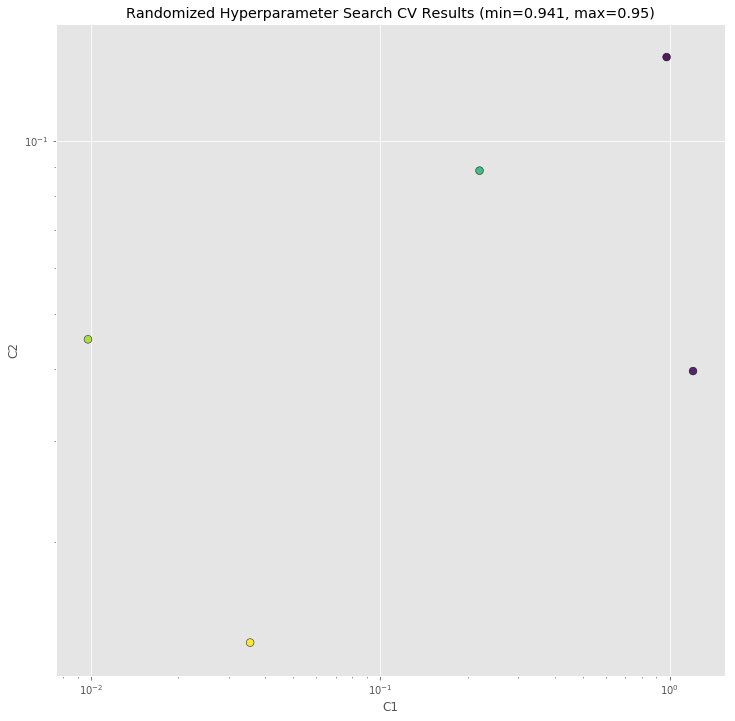

In [16]:
_x = [s.parameters['c1'] for s in rs.grid_scores_]
_y = [s.parameters['c2'] for s in rs.grid_scores_]
_c = [s.mean_validation_score for s in rs.grid_scores_]

fig = plt.figure()
fig.set_size_inches(12, 12)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_title("Randomized Hyperparameter Search CV Results (min={:0.3}, max={:0.3})".format(
    min(_c), max(_c)
))

ax.scatter(_x, _y, c=_c, s=60, alpha=0.9, edgecolors=[0,0,0])

print("dark blue => {:0.4}, yellow => {:0.4}".format(min(_c), max(_c)))

## Лучшие результаты


In [17]:
crf = rs.best_estimator_
y_pred = crf.predict(X_test)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

             precision    recall  f1-score   support

          X      0.827     0.692     0.753      4287
       PART      0.960     0.930     0.945      1606
        ADJ      0.931     0.941     0.936     10491
        ADP      0.997     0.997     0.997      8228
        ADV      0.928     0.936     0.932      2530
       VERB      0.949     0.977     0.963      7892
        DET      0.991     0.989     0.990      2343
       INTJ      0.892     0.674     0.768        86
       CONJ      0.976     0.983     0.980      4766
       NOUN      0.952     0.970     0.961     27615
       PRON      0.989     0.988     0.989      1580
      PROPN      0.788     0.775     0.781      2250
        NUM      0.994     0.994     0.994      1770
      PUNCT      1.000     0.995     0.997     20273

avg / total      0.957     0.958     0.957     95717



In [18]:
metrics.flat_f1_score(y_test, y_pred, 
                      average='weighted', labels=labels)

0.9571321615851478

## Что выучил классификатор

In [19]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

Top likely transitions:
X      -> X       2.688911
ADP    -> NOUN    2.229544
ADP    -> PROPN   2.198670
ADJ    -> NOUN    2.130471
PROPN  -> X       1.857679
X      -> PUNCT   1.790467
ADP    -> X       1.674431
NOUN   -> VERB    1.673873
NOUN   -> X       1.633919
ADV    -> VERB    1.630906
NUM    -> NOUN    1.610382
DET    -> NOUN    1.569932
X      -> NOUN    1.518248
NOUN   -> PROPN   1.485142
PROPN  -> PROPN   1.461027
X      -> VERB    1.420932
PRON   -> VERB    1.417215
ADP    -> PRON    1.365639
NOUN   -> NOUN    1.355801
INTJ   -> ADV     1.339223

Top unlikely transitions:
NUM    -> ADP     -1.265471
DET    -> INTJ    -1.281619
INTJ   -> ADP     -1.291472
NUM    -> VERB    -1.366818
NUM    -> DET     -1.482963
ADP    -> PUNCT   -1.493469
INTJ   -> DET     -1.509233
INTJ   -> CONJ    -1.597552
ADV    -> CONJ    -1.694541
INTJ   -> X       -1.765908
ADP    -> INTJ    -1.832272
ADP    -> ADP     -1.869055
ADJ    -> INTJ    -2.026860
INTJ   -> PRON    -2.086643
NUM    -> PRON   

In [22]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))    

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(20))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-20:])

Top positive:
16.535473 NUM      word.isdigit()
16.056149 PART     word.lower():не
14.482319 DET      word.lower():весь
14.146439 ADP      word.lower():на
13.775664 PRON     word.lower():собой
13.262462 DET      word.lower():который
13.086914 PART     word.lower():вот
13.047892 ADV      word.lower():более
12.791920 ADP      word.lower():за
12.750455 DET      word.lower():которые
12.552875 ADV      word.lower():ранее
12.235320 ADV      word.lower():столь
12.230782 DET      word.lower():те
12.189684 PART     word.lower():именно
12.027761 DET      word.lower():которых
12.005016 ADV      word.lower():сегодня
11.956390 ADJ      word.lower():готов
11.935598 ADV      word.lower():опять
11.933929 PRON     word.lower():меня
11.906505 CONJ     word.lower():но

Top negative:
-3.861938 ADP      EOS
-3.959096 VERB     -1:word.lower():совсем
-3.969491 CONJ     -1:word[-2:]:ря
-3.971811 NOUN     word[:2]:он
-3.973069 NOUN     word[-2:]:с
-4.070890 NOUN     word[-2:]:ую
-4.113177 ADV      +1:word.lowe